# Load Data

Here is the step that we load the data and give simple description about it.

In [1]:
import sys
!git clone https://github.com/z5365195Yuhao/elpv-dataset.git
sys.path.insert(0,'/content/elpv-dataset/utils')
from elpv_reader import load_dataset
images, proba, types = load_dataset()

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2689, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2689 (delta 0), reused 0 (delta 0), pack-reused 2688
Receiving objects: 100% (2689/2689), 90.79 MiB | 37.29 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
file_path = '/content/elpv-dataset/labels.csv'
df_labels = pd.read_csv(file_path, delimiter=' ', header=None)
# df_labels_new = df_labels[[0,2,19]]

In [4]:
df_labels_new = df_labels[[0,2,4,19]]

In [5]:
df_labels_new.columns = ['ImagePath', 'Label','Type_1', 'Type']
# df_labels_new

In [6]:
df_labels_new['Type'] = df_labels_new['Type'].combine_first(df_labels_new['Type_1'])
df_labels_new.drop(columns=['Type_1'], inplace=True)
# df_labels_new

<ipython-input-6-4591860754ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_new['Type'] = df_labels_new['Type'].combine_first(df_labels_new['Type_1'])
<ipython-input-6-4591860754ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_new.drop(columns=['Type_1'], inplace=True)


In [7]:
df_mono = df_labels_new[df_labels_new['Type'] == 'mono']
# df_mono

In [8]:
df_poly = df_labels_new[df_labels_new['Type'] == 'poly']
# df_poly

# Method 2 - Feature Extract + ML Model

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
import os
import random
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import plotly.graph_objects as go
import plotly.express as px

The train dataframe includes 75% of the data whereas the test dataset includes 25% of the original data.

In [10]:
test_size = 0.25
train_df, test_df = train_test_split(df_labels_new, test_size=test_size, random_state=42, stratify=df_labels_new['Label'])

In [11]:
######################################################
# This section of the code includes the processing of the training data
# and creating the augmented dataset for improving the accuracy of the
# model.
######################################################

# Initialise lists for processed image data
images_list = []
labels_list = []
label_zero_indexes = []
all_train_indexes = []

# The size of the image
image_size = 250


for index, row in train_df.iterrows():
    image_path = '/content/elpv-dataset/'+row['ImagePath']

    # Save the index of all images for data augmentation
    all_train_indexes.append(index)

    if os.path.exists(image_path):
        # Read the image
        image = cv2.imread(image_path)

        # Convert the image to gray scale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Re-size the image for processing
        image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)

        # Extract the channel for getting the image contrast
        channels = cv2.split(image)
        new_channels = []

        # Initialise the values
        a = 0
        b = 255

        for channel in channels:
            # the min and max pixcel values
            c, d = np.min(channel), np.max(channel)
            new_channel = (channel - c) * ((b - a) / (d - c)) + a
            new_channels.append(new_channel.astype(np.uint8))

        # combine all channels together
        output_image = cv2.merge(new_channels)

        # Append the image to the list
        images_list.append(output_image)

        # append the label
        labels_list.append(train_df['Label'][index])
    else:
        print(f"The file {image_path} does not exist")


######################### Data Augmentation ###########################

# Get the original number of images
range_val = len(images_list)
print("Original training images: ", range_val)

# Indexes for the classes that shouldn't be augmented
label_zero_indexes = []

for i in range(len(labels_list)):
    if labels_list[i] == 0.0 or labels_list[i] == 1.0:
        label_zero_indexes.append(i)

# Initialse lists for augmented data
aug_images = []
aug_labels = []

# The following value can be changed depending on the number of
# augmented images required
for i in range(350):
    # Create a set of all numbers in the range
    numbers_set = set(range(range_val))

    # Remove the numbers to exclude from the set
    numbers_to_pick_from = numbers_set - set(label_zero_indexes)
    numbers_to_pick_from_new = list(numbers_to_pick_from)

    random_integer = random.choice(numbers_to_pick_from_new)

    # random integer should be inside the bounds
    if random_integer >= range_val:
        raise IndexError(f"Index {random_integer} is out of bounds for images_list with length {range_val}")

    # Extract the image at the random integer index
    image = images_list[random_integer]

    # Flip the image horizontally
    flipped_image = cv2.flip(image, 1)

    # Append the values of the image to the augment list
    aug_images.append(flipped_image)
    aug_labels.append(labels_list[random_integer])

# Combine the original images and the augmented image lists
com_augmented_train = images_list + aug_images
com_augmented_labels = labels_list + aug_labels

# Convert the list of images to a NumPy array
images_array_train = np.array(com_augmented_train)
labels_array_train = np.array(com_augmented_labels)

print("Augmented training images: ", len(com_augmented_labels))

Original training images:  1968
Augmented training images:  2318


In [12]:
train_df['Label'].value_counts()

0.000000    1131
1.000000     536
0.333333     221
0.666667      80
Name: Label, dtype: int64

The above is the breakdown of the original class distribution.


In [13]:
df_new = pd.DataFrame(labels_array_train)
df_new.value_counts()

0.000000    1131
1.000000     536
0.333333     499
0.666667     152
dtype: int64

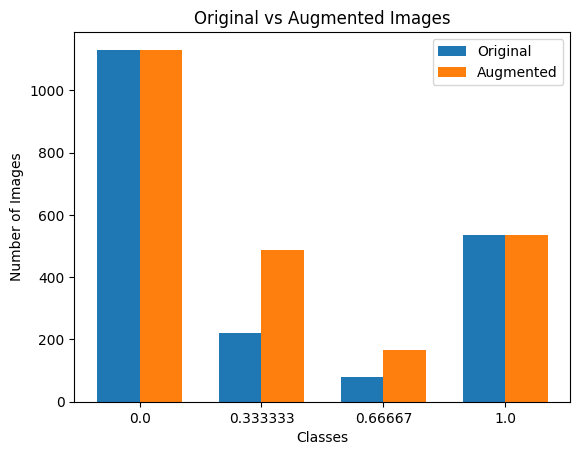

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['0.0', '0.333333', '0.66667', '1.0']
values1 = [1131, 221, 80, 536]
values2 = [1131, 486, 165, 536]

# Creating the x position of the bars
x = np.arange(len(categories))

# Width of a bar
width = 0.35

# Creating the bar chart
plt.bar(x - width/2, values1, width, label='Original')
plt.bar(x + width/2, values2, width, label='Augmented')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Original vs Augmented Images')
plt.xticks(x, categories)
plt.legend()

# Display the plot
plt.show()

The above is the breakdown of the augmented and original images. Due to the sampling apprach the classes with lower number of images are sampled higher. Specifically classes 0.333333 and 0.666667 have a higher number of image samples.

In [15]:
######################################################
# This section of the code includes the processing of the test data.
######################################################

# Lists for test data
images_list_test = []
labels_list_test = []

for index, row in test_df.iterrows():
    image_path = '/content/elpv-dataset/'+row['ImagePath']

    if os.path.exists(image_path):
        # read image
        image = cv2.imread(image_path)

        # convert to gray image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Re-size the images as  the train set
        image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)

        # extract the channgel
        channels = cv2.split(image)
        new_channels = []

        a = 0
        b = 255

        for channel in channels:
            # the min and max pixcel values
            c, d = np.min(channel), np.max(channel)
            new_channel = (channel - c) * ((b - a) / (d - c)) + a
            new_channels.append(new_channel.astype(np.uint8))

        # combine all channels together
        output_image = cv2.merge(new_channels)

        # Append the image to the list
        images_list_test.append(output_image)

        # append the label
        labels_list_test.append(test_df['Label'][index])
    else:
        print(f"The file {image_path} does not exist")

# Convert the list of images to a NumPy array
images_array_test = np.array(images_list_test)
labels_array_test = np.array(labels_list_test)

print("Testset includes", len(labels_array_test), "images.")

Testset includes 656 images.


### Data re-shaping

In the following section, the data is converted to a vector from the 2d matrix for easier processing with the machine learning model.

In [16]:
# For gray scale only need one channel
channel_num = 1

# Reshape the data
train_images_reshaped = images_array_train.reshape(images_array_train.shape[0], image_size*image_size*channel_num)
test_images_reshaped = images_array_test.reshape(images_array_test.shape[0], image_size*image_size*channel_num)

print("Reshaped train images shape:", train_images_reshaped.shape)
print("Reshaped test images shape:", test_images_reshaped.shape)

Reshaped train images shape: (2318, 62500)
Reshaped test images shape: (656, 62500)


In the following section the data in both the train and test sets are normalised.

In [17]:
train_images_reshaped = train_images_reshaped / 255.0
test_images_reshaped = test_images_reshaped / 255.0

In [18]:
# Convert the images into a dataframe
df_train_new = pd.DataFrame(train_images_reshaped)
df_test_new = pd.DataFrame(test_images_reshaped)
df_train_new

,0,1,2,3,4,5,6,7,8,9,...,62490,62491,62492,62493,62494,62495,62496,62497,62498,62499
0,0.239216,0.231373,0.223529,0.223529,0.215686,0.223529,0.231373,0.239216,0.239216,0.239216,...,0.019608,0.011765,0.011765,0.003922,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000
1,0.003922,0.003922,0.000000,0.003922,0.000000,0.003922,0.003922,0.003922,0.007843,0.007843,...,0.090196,0.082353,0.090196,0.090196,0.082353,0.082353,0.090196,0.090196,0.090196,0.090196
2,0.168627,0.172549,0.156863,0.152941,0.156863,0.137255,0.141176,0.152941,0.160784,0.172549,...,0.168627,0.168627,0.176471,0.180392,0.176471,0.160784,0.160784,0.168627,0.168627,0.168627
3,0.098039,0.094118,0.105882,0.113725,0.109804,0.109804,0.109804,0.105882,0.109804,0.113725,...,0.031373,0.031373,0.019608,0.015686,0.015686,0.019608,0.019608,0.007843,0.000000,0.007843
4,0.207843,0.211765,0.211765,0.219608,0.200000,0.200000,0.196078,0.196078,0.196078,0.196078,...,0.266667,0.266667,0.266667,0.266667,0.266667,0.262745,0.274510,0.278431,0.262745,0.250980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,0.125490,0.113725,0.101961,0.098039,0.098039,0.094118,0.094118,0.094118,0.082353,0.098039,...,0.090196,0.074510,0.066667,0.054902,0.031373,0.023529,0.011765,0.019608,0.019608,0.007843
2314,0.058824,0.058824,0.050980,0.047059,0.039216,0.039216,0.058824,0.062745,0.062745,0.062745,...,0.180392,0.176471,0.156863,0.133333,0.109804,0.094118,0.094118,0.094118,0.094118,0.094118
2315,0.003922,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.015686,0.023529,0.027451,...,0.027451,0.027451,0.023529,0.023529,0.023529,0.015686,0.015686,0.015686,0.015686,0.011765
2316,0.003922,0.003922,0.000000,0.000000,0.000000,0.003922,0.003922,0.003922,0.003922,0.011765,...,0.176471,0.176471,0.176471,0.172549,0.160784,0.160784,0.164706,0.172549,0.176471,0.176471


In [19]:
# Convert the original format of the output column to [0, 1, 2, 3]
# This allows for easier processing
train_y = (labels_array_train * 3).astype(int)
test_y = (labels_array_test * 3).astype(int)
train_y

array([1, 0, 1, ..., 1, 2, 1])

In [20]:
# Create keypoints

# initialise step size and scale
step_size=20
scale=1.0

# lists for adding the required information
key_features = []
key_features_all = []


for i in images_array_test:

    # Read each of the gray images
    gray = i

    # Extract the SIFT features
    sift = cv2.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.06, edgeThreshold = 10, sigma = 1.6)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Key feature list for each of the images
    key_features = []

    # Add the number of key points as a feature for each image
    key_features.append(len(keypoints))

    ####################### Find the edges #######################

    # Apply GaussianBlur to reduce image noise if it is required
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detector to detect edges
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)


    # if no lines are detected, let the count be 0
    if lines is not None:
        number_of_lines = len(lines)
    else:
        number_of_lines = 0

    # Append the number of lines as the second feature
    key_features.append(number_of_lines)

    ######### key values of the SIFT Features ############

    # Same as above, however, the number of features has a cap to avoid
    # major number of missing values for some features
    sift_2 = cv2.SIFT_create(nfeatures = 15,  nOctaveLayers = 3, contrastThreshold = 0.08, edgeThreshold = 15, sigma = 1.6)

    # Get key features and descriptors
    keypoints, descriptors = sift_2.detectAndCompute(gray, None)

    for i in keypoints:
        angle = i.angle
        response = i.response
        size = i.size

        # Extract the following values for each key feature
        # and sppend to the list of features
        key_features.append(size)
        key_features.append(angle)
        key_features.append(response)

    ##################### ORB features #################
    orb = cv2.ORB_create(nfeatures = 5)

    # Find keypoints and descriptors
    keypoints_orb, descriptors_orb = orb.detectAndCompute(gray, None)

    # Similar to above all key features are appended to the list
    for i in keypoints_orb:
        angle = i.angle
        response = i.response
        size = i.size

        key_features.append(size)
        key_features.append(angle)
        key_features.append(response)

    # Append each feature to all feature list
    key_features_all.append(key_features)

df_key_test = pd.DataFrame(key_features_all).iloc[:, :51]
df_key_test

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,16,10,6.485844,6.346512,0.041512,6.648381,0.401688,0.034159,7.013373,3.338737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,154,11,5.906448,90.710220,0.051919,5.406739,272.522400,0.053701,5.458381,83.679504,...,6.199550,87.706566,0.051762,6.199550,275.628204,0.051762,31.000000,72.142052,0.000057,37.200001
2,185,10,6.719050,260.288391,0.049276,6.020926,88.947296,0.066334,6.719050,95.918884,...,17.205708,2.982559,0.045932,4.758262,280.150818,0.045562,31.000000,173.352295,0.000139,37.200001
3,43,11,10.152336,237.876465,0.039546,6.701633,342.773712,0.044592,17.555815,320.326324,...,3.894116,97.802872,0.036450,3.769695,98.726746,0.033957,NaN,NaN,NaN,NaN
4,23,11,5.088828,273.283813,0.032405,20.555622,51.148415,0.036415,4.943339,85.648499,...,5.055527,274.503754,0.031461,5.258513,97.872070,0.030451,5.258513,262.797546,0.030451,31.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,61,12,6.737939,276.933472,0.046854,32.989632,317.549622,0.048255,8.999787,276.882874,...,6.698774,102.496017,0.044933,8.713435,83.243393,0.042092,31.000000,67.526237,0.000012,37.200001
652,31,9,7.836729,257.174774,0.036900,12.125116,357.071198,0.039075,12.611994,357.788513,...,8.193644,270.296417,0.033017,20.400484,97.736397,0.032985,44.640003,89.844429,0.000005,53.568005
653,89,7,10.897432,352.630280,0.032004,8.886384,81.765686,0.036686,8.312241,185.883606,...,25.972034,59.601402,0.030972,25.972034,252.140152,0.030972,31.000000,24.762154,0.000015,37.200001
654,156,9,7.640077,277.393127,0.069922,10.161540,104.521698,0.073340,10.161540,250.199646,...,7.133018,263.811523,0.064994,8.048415,268.068329,0.064220,8.048415,88.743988,0.064220,31.000000


In [21]:
# Create keypoints

# initialise step size and scale
step_size=20
scale=1.0

# lists for key features
key_features = []
key_features_all = []


for i in images_array_train:

    # read the gray image
    gray = i

    # The following functionality is same as the above cell, but just for the testset
    sift = cv2.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.06, edgeThreshold = 10, sigma = 1.6)

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    key_features = []
    key_features.append(len(keypoints))

    ####################### Find the edges #######################

    # Apply GaussianBlur to reduce image noise if it is required
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detector to detect edges
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    # If the no lines, let it be 0
    if lines is not None:
        number_of_lines = len(lines)
    else:
        number_of_lines = 0

    key_features.append(number_of_lines)


    #############################
    sift = cv2.SIFT_create(nfeatures = 15,  nOctaveLayers = 3, contrastThreshold = 0.08, edgeThreshold = 15, sigma = 1.6)

    # Get key features and descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    for i in keypoints:
        angle = i.angle
        response = i.response
        size = i.size

        key_features.append(size)
        key_features.append(angle)
        key_features.append(response)


    #######################################
    orb = cv2.ORB_create(nfeatures = 5)

    # Find keypoints and descriptors
    keypoints_orb, descriptors_orb = orb.detectAndCompute(gray, None)

    for i in keypoints_orb:
        angle = i.angle
        response = i.response
        size = i.size

        key_features.append(size)
        key_features.append(angle)
        key_features.append(response)


    key_features_all.append(key_features)


df_key_train = pd.DataFrame(key_features_all).iloc[:, :51]
df_key_train

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,105,12,6.345007,93.283386,0.041345,6.033571,89.823112,0.042051,6.180360,264.324493,...,6.300835,269.953583,0.037649,6.955133,11.393776,0.034918,31.000000,258.076538,0.000008,37.200001
1,30,10,5.388910,84.569244,0.044587,5.122563,85.249268,0.046324,5.341063,265.139526,...,5.306636,265.410065,0.044517,5.306636,96.877960,0.044517,31.000000,167.536530,0.000024,37.200001
2,142,11,6.382989,183.567688,0.042170,4.356088,168.998291,0.045159,4.849506,106.179291,...,7.190271,39.258919,0.041983,7.190271,200.151627,0.041983,31.000000,6.545665,0.000025,37.200001
3,93,10,6.658527,265.545532,0.068844,6.658527,94.514709,0.068844,6.540129,265.524689,...,6.700887,95.552254,0.067761,6.376303,87.339668,0.067470,6.376303,272.451599,0.067470,31.000000
4,216,10,18.418699,260.854126,0.061912,10.641695,179.733963,0.064445,12.745193,269.494537,...,5.211189,268.128754,0.053681,35.284195,236.382309,0.053008,31.000000,228.154358,0.000233,37.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,199,10,4.933036,277.766479,0.060034,5.526931,91.902313,0.060731,5.526931,269.349091,...,6.859760,90.878662,0.057107,6.119518,96.824341,0.056874,31.000000,214.502350,0.000058,37.200001
2314,170,10,4.700547,286.577972,0.042763,4.322635,184.625854,0.044062,5.029064,186.098251,...,4.700547,80.065193,0.042763,4.804666,175.757538,0.041179,31.000000,280.702484,0.000083,37.200001
2315,26,9,3.686922,75.563774,0.038939,3.686922,288.837616,0.038939,7.935566,356.414612,...,7.991489,180.312057,0.039922,8.031890,177.678284,0.045001,NaN,NaN,NaN,NaN
2316,96,8,7.331259,84.706711,0.039806,5.856937,131.727295,0.048005,7.237839,105.246796,...,8.542995,267.610809,0.048265,8.643311,88.072815,0.039021,31.000000,84.363426,0.000013,37.200001


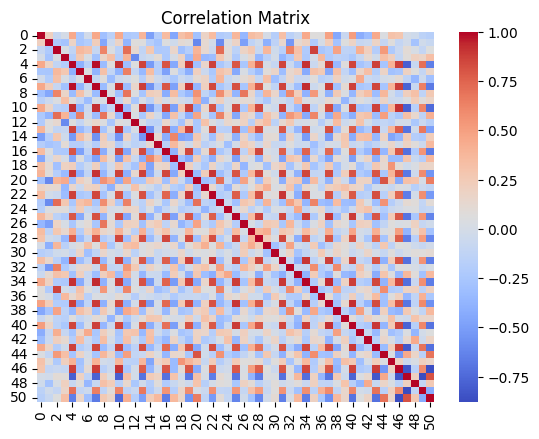

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# corelation matrix for the new features
correlation_matrix = df_key_train[:30].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [23]:
# Using the mean value of each column to fill the missing values
means_test = df_key_train.mean()
df_key_train_updated = df_key_train.fillna(means_test)

In [24]:
# Using the mean value of each column to fill the missing values
means_train = df_key_test.mean()
df_key_test_updated =  df_key_test.fillna(means_train)

In [25]:
# Combine the image pixel feature dataset and the key features extracted together
result_test = pd.concat([df_test_new, df_key_test_updated], axis=1)
result_train = pd.concat([df_train_new, df_key_train_updated], axis=1)
result_train


# result_test = df_test_new
# result_train = df_train_new
# result_train

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.239216,0.231373,0.223529,0.223529,0.215686,0.223529,0.231373,0.239216,0.239216,0.239216,...,6.300835,269.953583,0.037649,6.955133,11.393776,0.034918,31.000000,258.076538,0.000008,37.200001
1,0.003922,0.003922,0.000000,0.003922,0.000000,0.003922,0.003922,0.003922,0.007843,0.007843,...,5.306636,265.410065,0.044517,5.306636,96.877960,0.044517,31.000000,167.536530,0.000024,37.200001
2,0.168627,0.172549,0.156863,0.152941,0.156863,0.137255,0.141176,0.152941,0.160784,0.172549,...,7.190271,39.258919,0.041983,7.190271,200.151627,0.041983,31.000000,6.545665,0.000025,37.200001
3,0.098039,0.094118,0.105882,0.113725,0.109804,0.109804,0.109804,0.105882,0.109804,0.113725,...,6.700887,95.552254,0.067761,6.376303,87.339668,0.067470,6.376303,272.451599,0.067470,31.000000
4,0.207843,0.211765,0.211765,0.219608,0.200000,0.200000,0.196078,0.196078,0.196078,0.196078,...,5.211189,268.128754,0.053681,35.284195,236.382309,0.053008,31.000000,228.154358,0.000233,37.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,0.125490,0.113725,0.101961,0.098039,0.098039,0.094118,0.094118,0.094118,0.082353,0.098039,...,6.859760,90.878662,0.057107,6.119518,96.824341,0.056874,31.000000,214.502350,0.000058,37.200001
2314,0.058824,0.058824,0.050980,0.047059,0.039216,0.039216,0.058824,0.062745,0.062745,0.062745,...,4.700547,80.065193,0.042763,4.804666,175.757538,0.041179,31.000000,280.702484,0.000083,37.200001
2315,0.003922,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.015686,0.023529,0.027451,...,7.991489,180.312057,0.039922,8.031890,177.678284,0.045001,24.558268,182.900477,0.015659,36.152833
2316,0.003922,0.003922,0.000000,0.000000,0.000000,0.003922,0.003922,0.003922,0.003922,0.011765,...,8.542995,267.610809,0.048265,8.643311,88.072815,0.039021,31.000000,84.363426,0.000013,37.200001


In [26]:
# Conver the output columns into an dataframe for easier processing
df_train_y = pd.DataFrame(train_y)
df_test_y = pd.DataFrame(test_y)
df_test_y

,0
0,2
1,0
2,0
3,3
4,0
...,...
651,3
652,1
653,1
654,1


In [27]:
# from sklearn.model_selection import GridSearchCV

# # defining parameter range
# param_grid = {# 'C': ['scale', 'auto', 0.1, 1, 10],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}

# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# grid.fit(result_train, df_train_y)

In [28]:
# find the best parameters
# print(grid.best_params_)
# print(grid.best_estimator_)

In [29]:
# from sklearn.metrics import classification_report, confusion_matrix

# grid_predictions = grid.predict(result_test)

# # print classification report
# print(classification_report(df_test_y, grid_predictions))

In [27]:
# C=100000,
# create the SVM
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto', verbose=True))
# pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', verbose=True))

# Train the SVM model on the training data
pipeline.fit(result_train, df_train_y)

# Make predictions on the test data
y_pred = pipeline.predict(result_test)
y_pred_new = pd.DataFrame(y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
# print classification report
print(classification_report(df_test_y, y_pred_new))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       377
           1       0.57      0.27      0.37        74
           2       0.00      0.00      0.00        26
           3       0.83      0.62      0.71       179

    accuracy                           0.74       656
   macro avg       0.53      0.46      0.47       656
weighted avg       0.71      0.74      0.70       656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
y_pred_new =  pd.DataFrame(y_pred)
accur = accuracy_score(df_test_y, y_pred)
updated_accur = accur*100
print(f"Accuracy of the model is {updated_accur}%")

Accuracy of the model is 73.6280487804878%


In [30]:

# Overall confusion matrix and the plotly figure
conf_matrix = confusion_matrix(df_test_y, y_pred_new)
fig = px.imshow(conf_matrix, text_auto=True, labels=dict(x="Predictions", y="Actual values", color="SVM performance"),
                x=['0.0', '0.333333', '0.666667', '1.0'],
                y=['0.0', '0.333333', '0.666667', '1.0'])
fig.show()

In [31]:
warnings.filterwarnings('ignore')
precision = precision_score(df_test_y, y_pred, average='macro')
recall = recall_score(df_test_y, y_pred, average='macro')
f1 = f1_score(df_test_y, y_pred, average='macro')

print("Overall Performance of the model")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Overall Performance of the model
Precision: 0.5318316282509553
Recall: 0.45601725119159137
F1: 0.47309594274315603


In [32]:
# Convert to a dataframe and rename
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.rename(columns={0: 'pred_value'}, inplace=True)

In [33]:
# Re indexing the test dataset
new_index = range(0, len(test_df))
test_df.index = new_index

# Combining the predictions
combined_df = pd.concat([test_df, y_pred_df], axis=1)

In [34]:
df_mono = combined_df[combined_df['Type'] == 'mono']
df_poly = combined_df[combined_df['Type'] == 'poly']

#### Mono Prediction results

In [35]:
# Overall confusion matrix and the plotly figure
df_mono_label = (df_mono['Label']*3).astype(int)
conf_matrix = confusion_matrix(df_mono_label, df_mono['pred_value'])
fig = px.imshow(conf_matrix, text_auto=True, labels=dict(x="Predictions", y="Actual values", color="SVM performance"),
                x=['0.0', '0.333333', '0.666667', '1.0'],
                y=['0.0', '0.333333', '0.666667', '1.0'])
fig.show()

In [36]:
df_mono['pred_value'].unique()

array([0, 3, 1])

In [37]:
warnings.filterwarnings('ignore')
precision = precision_score(df_mono_label, df_mono['pred_value'], average='macro')
recall = recall_score(df_mono_label, df_mono['pred_value'], average='macro')
f1 = f1_score(df_mono_label, df_mono['pred_value'], average='macro')

accur = accuracy_score(df_mono_label, df_mono['pred_value'])
updated_accur = accur*100
print(f"Accuracy of the model is {updated_accur}%")

print("Mono Performance of the model")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy of the model is 74.80916030534351%
Mono Performance of the model
Precision: 0.5381076388888889
Recall: 0.5078291091750385
F1: 0.5149419571129489


#### Poly Prediction Results

In [38]:
# Overall confusion matrix and the plotly figure
df_poly_label = (df_poly['Label']*3).astype(int)
conf_matrix_poly = confusion_matrix(df_poly_label, df_poly['pred_value'])
fig = px.imshow(conf_matrix_poly, text_auto=True, labels=dict(x="Predictions", y="Actual values", color="SVM performance"),
                x=['0.0', '0.333333', '0.666667', '1.0'],
                y=['0.0', '0.333333', '0.666667', '1.0'])
fig.show()

In [39]:
warnings.filterwarnings('ignore')
precision = precision_score(df_poly_label, df_poly['pred_value'], average='macro')
recall = recall_score(df_poly_label, df_poly['pred_value'], average='macro')
f1 = f1_score(df_poly_label, df_poly['pred_value'], average='macro')

accur = accuracy_score(df_poly_label, df_poly['pred_value'])
updated_accur = accur*100
print(f"Accuracy of the model is {updated_accur}%")

print("Poly Performance of the model")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy of the model is 72.84263959390863%
Poly Performance of the model
Precision: 0.5266922974723486
Recall: 0.4243117675611955
F1: 0.44238454574692376
